# Recurrent DQN

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

# Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
# import numpy as np
# state = env.reset()
# for _ in range(10):
#     # env.render()
#     action = env.action_space.sample()
#     next_state, reward, done, info = env.step(action) # take a random action
#     #print('state, action, next_state, reward, done, info:', state, action, next_state, reward, done, info)
#     state = next_state
#     if done:
#         state = env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size, hidden_size, batch_size=1):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    # RNN
    cell = tf.nn.rnn_cell.GRUCell(hidden_size)
    #cell = tf.nn.rnn_cell.LSTMCell(hidden_size)
    cells = tf.nn.rnn_cell.MultiRNNCell([cell], state_is_tuple=True)
    initial_state = cells.zero_state(batch_size, tf.float32)
    return states, actions, targetQs, cells, initial_state

In [6]:
# RNN generator or sequence generator
def generator(states, action_size, initial_state, cells, hidden_size, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=hidden_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size and
        # static means can NOT adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, hidden_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cells, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state)
        outputs = tf.reshape(outputs_rnn, [-1, hidden_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=action_size)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [7]:
def model_loss(action_size, hidden_size, states, cells, initial_state, actions, targetQs):
    actions_logits, final_state = generator(states=states, cells=cells, initial_state=initial_state, 
                                            hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, final_state, loss

In [8]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # # Optimize MLP/CNN
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    # # Optimize RNN
    #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    grads = tf.gradients(loss, g_vars)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, g_vars))

    return opt

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, cells, self.initial_state = model_input(
                state_size=state_size, hidden_size=hidden_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, cells=cells, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [10]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [42]:
# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 128            # memory capacity - 1000 DQN
batch_size = 128             # experience mini-batch size - 20 DQN
gamma = 0.99                 # future reward discount

In [43]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (<tf.Tensor 'MultiRNNCellZeroState/GRUCellZeroState/zeros:0' shape=(1, 64) dtype=float32>,)
(1, ?, 64) (<tf.Tensor 'generator/rnn/while/Exit_3:0' shape=(1, 64) dtype=float32>,)
(?, 64)
(?, 2)


In [44]:
model.initial_state[0]

<tf.Tensor 'MultiRNNCellZeroState/GRUCellZeroState/zeros:0' shape=(1, 64) dtype=float32>

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [45]:
import numpy as np
state = env.reset()
# for _ in range(memory_size):
for _ in range(1000):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.states.append(np.zeros([1, hidden_size])) # gru
    #memory.states.append([np.zeros([1, hidden_size]), np.zeros([1, hidden_size])]) # lstm
    state = next_state
    
    batch = memory.buffer
    dones = np.array([each[4] for each in batch])
    if np.any(dones) != 1:
    #if np.all(dones) == 0:
        print('all zero', dones)
    else:
        print('all not zero', dones)

    if done is True:
        # Reseting the env/first state
        state = env.reset()

all zero [0.]
all zero [0. 0.]
all zero [0. 0. 0.]
all zero [0. 0. 0. 0.]
all zero [0. 0. 0. 0. 0.]
all zero [0. 0. 0. 0. 0. 0.]
all zero [0. 0. 0. 0. 0. 0. 0.]
all zero [0. 0. 0. 0. 0. 0. 0. 0.]
all zero [0. 0. 0. 0. 0. 0. 0. 0. 0.]
all zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
all zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
all zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
all zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
all zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
all zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
all zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
all not zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
all not zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
all not zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
all not zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
all not zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
all not zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

 0. 0. 0. 0. 0. 0. 0. 0.]
all not zero [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
all not zero [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
all not zero [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 

 0. 0. 0. 0. 0. 0. 1. 0.]
all not zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0.]
all not zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0.]
all not zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

 0. 0. 0. 0. 0. 0. 0. 0.]
all not zero [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
all not zero [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1.]
all not zero [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 

all not zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
all not zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
all not zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 1.]
all not zero [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0.]
all not zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0.]
all not zero [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

 0. 0. 0. 0. 0. 0. 1. 0.]
all not zero [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0.]
all not zero [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0.]
all not zero [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 

In [46]:
# Training
batch = memory.buffer
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])

In [47]:
np.all(dones) == 0

True

In [48]:
dones

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [49]:
memory.states[0].shape, model.initial_state[0].shape # gru
# memory.states[0][1].shape, model.initial_state[0][1].shape #lstm

((1, 64), TensorShape([Dimension(1), Dimension(64)]))

In [50]:
memory.states[0][0].shape, model.initial_state[0][0].shape

((64,), TensorShape([Dimension(64)]))

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [51]:
# initial_states = np.array(memory.states)
# initial_states.shape

In [52]:
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        initial_state = sess.run(model.initial_state)

        # Training steps/batches
        while True:
            action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                                  feed_dict = {model.states: state.reshape([1, -1]), 
                                                               model.initial_state: initial_state})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append(initial_state)
            total_reward += reward
            state = next_state
            initial_state = final_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            initial_states = memory.states
            if total_reward < batch_size*2:
                next_actions_logits = sess.run(model.actions_logits, 
                               feed_dict = {model.states: next_states,
                                            model.initial_state: initial_states[1]})
                nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
                targetQs = rewards + (gamma * nextQs)
                loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.targetQs: targetQs,
                                                                         model.initial_state: initial_states[0]})
            #if total_reward >= batch_size*2:
            else:
                if np.any(dones) != 1:
                    next_actions_logits = sess.run(model.actions_logits, 
                                                   feed_dict = {model.states: next_states,
                                                                model.initial_state: initial_states[1]})
                    nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
                    targetQs = rewards + (gamma * nextQs)
                    loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                             model.actions: actions,
                                                                             model.targetQs: targetQs,
                                                                             model.initial_state: initial_states[0]})


                
            # End of training
            loss_batch.append(loss)
            if done is True:
                break
                
        # Outputing: priting out/Potting
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:84.0000 R:84.0000 loss:1.2452
Episode:1 meanR:82.5000 R:81.0000 loss:1.3180
Episode:2 meanR:66.3333 R:34.0000 loss:1.7147
Episode:3 meanR:57.0000 R:29.0000 loss:1.7919
Episode:4 meanR:52.0000 R:32.0000 loss:1.8896
Episode:5 meanR:48.3333 R:30.0000 loss:2.0102
Episode:6 meanR:46.5714 R:36.0000 loss:2.1502
Episode:7 meanR:45.8750 R:41.0000 loss:2.0995
Episode:8 meanR:44.5556 R:34.0000 loss:2.1731
Episode:9 meanR:42.6000 R:25.0000 loss:2.4013
Episode:10 meanR:40.6364 R:21.0000 loss:2.5752
Episode:11 meanR:39.0000 R:21.0000 loss:2.9119
Episode:12 meanR:37.3846 R:18.0000 loss:3.2606
Episode:13 meanR:36.0000 R:18.0000 loss:3.7624
Episode:14 meanR:34.7333 R:17.0000 loss:3.9210
Episode:15 meanR:33.7500 R:19.0000 loss:4.2354
Episode:16 meanR:32.7059 R:16.0000 loss:4.5009
Episode:17 meanR:31.7222 R:15.0000 loss:4.5633
Episode:18 meanR:30.8421 R:15.0000 loss:4.8602
Episode:19 meanR:30.3000 R:20.0000 loss:5.0087
Episode:20 meanR:29.7143 R:18.0000 loss:5.0035
Episode:21 meanR:29.136

Episode:172 meanR:34.8400 R:21.0000 loss:5.3279
Episode:173 meanR:34.7200 R:22.0000 loss:5.6323
Episode:174 meanR:34.3200 R:19.0000 loss:5.6327
Episode:175 meanR:33.7500 R:22.0000 loss:5.0084
Episode:176 meanR:32.9600 R:23.0000 loss:3.8348
Episode:177 meanR:32.5300 R:19.0000 loss:3.4079
Episode:178 meanR:32.2400 R:24.0000 loss:3.5831
Episode:179 meanR:31.8000 R:29.0000 loss:2.1447
Episode:180 meanR:31.5200 R:28.0000 loss:1.0700
Episode:181 meanR:31.4400 R:28.0000 loss:0.6149
Episode:182 meanR:31.2800 R:25.0000 loss:0.5042
Episode:183 meanR:31.2300 R:20.0000 loss:0.4015
Episode:184 meanR:31.2000 R:21.0000 loss:0.3703
Episode:185 meanR:31.1400 R:19.0000 loss:0.4167
Episode:186 meanR:31.2100 R:24.0000 loss:0.5374
Episode:187 meanR:31.2500 R:23.0000 loss:0.8225
Episode:188 meanR:31.3400 R:22.0000 loss:0.7149
Episode:189 meanR:31.4300 R:23.0000 loss:0.8716
Episode:190 meanR:31.5400 R:25.0000 loss:0.7356
Episode:191 meanR:31.6500 R:25.0000 loss:0.4945
Episode:192 meanR:31.7200 R:19.0000 loss

Episode:340 meanR:54.2800 R:172.0000 loss:1.4187
Episode:341 meanR:55.1600 R:130.0000 loss:8.1740
Episode:342 meanR:56.2600 R:155.0000 loss:5.5570
Episode:343 meanR:56.9700 R:118.0000 loss:7.2271
Episode:344 meanR:57.9300 R:122.0000 loss:7.5011
Episode:345 meanR:59.1900 R:151.0000 loss:12.4703
Episode:346 meanR:61.2700 R:234.0000 loss:4.9201
Episode:347 meanR:61.9000 R:94.0000 loss:37.4530
Episode:348 meanR:62.0800 R:58.0000 loss:22.2020
Episode:349 meanR:62.5500 R:74.0000 loss:25.5830
Episode:350 meanR:63.6200 R:128.0000 loss:17.2872
Episode:351 meanR:63.8600 R:65.0000 loss:13.4651
Episode:352 meanR:63.8600 R:40.0000 loss:26.3211
Episode:353 meanR:63.8500 R:40.0000 loss:33.0341
Episode:354 meanR:63.8000 R:38.0000 loss:37.7658
Episode:355 meanR:63.9700 R:66.0000 loss:35.3143
Episode:356 meanR:64.1000 R:45.0000 loss:31.9624
Episode:357 meanR:63.8800 R:39.0000 loss:29.9356
Episode:358 meanR:63.7600 R:52.0000 loss:34.9697
Episode:359 meanR:63.8000 R:58.0000 loss:29.6124
Episode:360 meanR:

Episode:507 meanR:207.0200 R:101.0000 loss:2.5983
Episode:508 meanR:210.0100 R:482.0000 loss:1.4423
Episode:509 meanR:213.7500 R:500.0000 loss:0.4579
Episode:510 meanR:217.6300 R:500.0000 loss:17.5771
Episode:511 meanR:218.6400 R:172.0000 loss:13.6567
Episode:512 meanR:222.5600 R:500.0000 loss:2.6222
Episode:513 meanR:227.1000 R:500.0000 loss:8.3954
Episode:514 meanR:231.0600 R:500.0000 loss:7.5606
Episode:515 meanR:231.5300 R:168.0000 loss:50.6743
Episode:516 meanR:236.2400 R:500.0000 loss:0.9199
Episode:517 meanR:240.9400 R:500.0000 loss:17.4684
Episode:518 meanR:243.4800 R:364.0000 loss:23.3802
Episode:519 meanR:247.4900 R:500.0000 loss:3.4812
Episode:520 meanR:250.0300 R:386.0000 loss:21.6207
Episode:521 meanR:250.4600 R:179.0000 loss:24.6465
Episode:522 meanR:250.8400 R:149.0000 loss:3.0430
Episode:523 meanR:254.7500 R:500.0000 loss:0.7482
Episode:524 meanR:258.6000 R:500.0000 loss:16.3453
Episode:525 meanR:259.1000 R:168.0000 loss:50.3258
Episode:526 meanR:262.4500 R:500.0000 los

Episode:669 meanR:412.7100 R:109.0000 loss:1.4265
Episode:670 meanR:409.0300 R:132.0000 loss:3.0628
Episode:671 meanR:405.3500 R:132.0000 loss:0.7500
Episode:672 meanR:402.1700 R:182.0000 loss:1.6226
Episode:673 meanR:398.4300 R:126.0000 loss:2.0153
Episode:674 meanR:396.6800 R:325.0000 loss:8.6281
Episode:675 meanR:395.6600 R:398.0000 loss:1.4458
Episode:676 meanR:392.2100 R:155.0000 loss:0.9871
Episode:677 meanR:393.1900 R:305.0000 loss:5.8892
Episode:678 meanR:389.4000 R:121.0000 loss:3.7369
Episode:679 meanR:390.3200 R:197.0000 loss:7.8405
Episode:680 meanR:391.6800 R:500.0000 loss:7.3314
Episode:681 meanR:392.2700 R:169.0000 loss:27.7601
Episode:682 meanR:389.2100 R:139.0000 loss:3.0176
Episode:683 meanR:386.2600 R:126.0000 loss:1.8090
Episode:684 meanR:382.8500 R:156.0000 loss:1.0055
Episode:685 meanR:382.7700 R:482.0000 loss:1.2904
Episode:686 meanR:379.4300 R:166.0000 loss:7.6552
Episode:687 meanR:379.0700 R:216.0000 loss:4.0830
Episode:688 meanR:379.0700 R:500.0000 loss:4.4485

Episode:831 meanR:441.3100 R:500.0000 loss:7.3519
Episode:832 meanR:436.5700 R:26.0000 loss:77.9716
Episode:833 meanR:432.5600 R:99.0000 loss:106.4900
Episode:834 meanR:431.6000 R:404.0000 loss:9.0373
Episode:835 meanR:431.6000 R:500.0000 loss:2.1465
Episode:836 meanR:431.6000 R:500.0000 loss:13.5659
Episode:837 meanR:431.5400 R:494.0000 loss:10.7509
Episode:838 meanR:430.3100 R:377.0000 loss:11.9281
Episode:839 meanR:430.3100 R:500.0000 loss:6.4966
Episode:840 meanR:427.2600 R:195.0000 loss:7.2868
Episode:841 meanR:424.3300 R:207.0000 loss:5.8890
Episode:842 meanR:420.9900 R:166.0000 loss:5.3101
Episode:843 meanR:417.2600 R:127.0000 loss:3.0353
Episode:844 meanR:413.4600 R:120.0000 loss:2.3757
Episode:845 meanR:409.6400 R:118.0000 loss:1.6807
Episode:846 meanR:405.6300 R:99.0000 loss:1.0585
Episode:847 meanR:401.6200 R:99.0000 loss:1.8580
Episode:848 meanR:397.5700 R:95.0000 loss:1.3699
Episode:849 meanR:393.4600 R:89.0000 loss:1.3092
Episode:850 meanR:389.2500 R:79.0000 loss:1.3615
E

Episode:995 meanR:176.5900 R:128.0000 loss:0.1711
Episode:996 meanR:172.8500 R:126.0000 loss:0.2047
Episode:997 meanR:169.1700 R:132.0000 loss:0.3947
Episode:998 meanR:166.5800 R:136.0000 loss:0.2280
Episode:999 meanR:165.6400 R:137.0000 loss:0.3075
Episode:1000 meanR:165.6700 R:135.0000 loss:0.4119
Episode:1001 meanR:162.7500 R:133.0000 loss:0.3209
Episode:1002 meanR:162.3900 R:138.0000 loss:0.3582
Episode:1003 meanR:162.1900 R:148.0000 loss:0.3626
Episode:1004 meanR:161.8200 R:152.0000 loss:0.2333
Episode:1005 meanR:158.3000 R:148.0000 loss:0.2902
Episode:1006 meanR:157.7500 R:148.0000 loss:0.2598
Episode:1007 meanR:154.2300 R:148.0000 loss:0.6428
Episode:1008 meanR:150.6000 R:137.0000 loss:2.0633
Episode:1009 meanR:146.9500 R:135.0000 loss:0.7224
Episode:1010 meanR:143.3000 R:135.0000 loss:6.2591
Episode:1011 meanR:139.5400 R:124.0000 loss:6.3506
Episode:1012 meanR:135.7500 R:121.0000 loss:12.7770
Episode:1013 meanR:132.4100 R:117.0000 loss:5.5180
Episode:1014 meanR:130.6100 R:106.0

Episode:1155 meanR:427.1400 R:500.0000 loss:18.5984
Episode:1156 meanR:431.3600 R:500.0000 loss:17.6299
Episode:1157 meanR:431.9100 R:289.0000 loss:36.5939
Episode:1158 meanR:435.8500 R:500.0000 loss:4.6456
Episode:1159 meanR:439.7100 R:500.0000 loss:11.7272
Episode:1160 meanR:443.4400 R:500.0000 loss:17.2233
Episode:1161 meanR:446.9500 R:500.0000 loss:21.0660
Episode:1162 meanR:450.3100 R:500.0000 loss:19.1007
Episode:1163 meanR:451.4800 R:500.0000 loss:18.3475
Episode:1164 meanR:454.9600 R:500.0000 loss:18.2463
Episode:1165 meanR:455.9500 R:500.0000 loss:19.6798
Episode:1166 meanR:455.9500 R:500.0000 loss:16.6862
Episode:1167 meanR:458.5400 R:500.0000 loss:15.2588
Episode:1168 meanR:458.5400 R:500.0000 loss:17.4586
Episode:1169 meanR:458.5400 R:500.0000 loss:18.5509
Episode:1170 meanR:458.5400 R:500.0000 loss:14.9461
Episode:1171 meanR:458.5400 R:500.0000 loss:17.2997
Episode:1172 meanR:458.5400 R:500.0000 loss:15.3001
Episode:1173 meanR:455.8300 R:229.0000 loss:41.4722
Episode:1174 

Episode:1314 meanR:279.0600 R:500.0000 loss:17.4166
Episode:1315 meanR:283.9200 R:500.0000 loss:14.5835
Episode:1316 meanR:288.7700 R:500.0000 loss:16.1727
Episode:1317 meanR:293.6300 R:500.0000 loss:14.4283
Episode:1318 meanR:298.4900 R:500.0000 loss:13.0889
Episode:1319 meanR:303.3800 R:500.0000 loss:16.9614
Episode:1320 meanR:308.1700 R:500.0000 loss:16.8850
Episode:1321 meanR:312.9800 R:500.0000 loss:16.0655
Episode:1322 meanR:317.8000 R:500.0000 loss:16.2400
Episode:1323 meanR:322.5600 R:500.0000 loss:16.0852
Episode:1324 meanR:327.3900 R:500.0000 loss:15.4102
Episode:1325 meanR:331.4800 R:500.0000 loss:14.8638
Episode:1326 meanR:335.5700 R:500.0000 loss:14.7479
Episode:1327 meanR:339.4700 R:500.0000 loss:14.0121
Episode:1328 meanR:343.1400 R:500.0000 loss:14.8434
Episode:1329 meanR:346.8400 R:500.0000 loss:13.7253
Episode:1330 meanR:350.6000 R:500.0000 loss:14.3504
Episode:1331 meanR:354.4000 R:500.0000 loss:13.1192
Episode:1332 meanR:358.1600 R:500.0000 loss:14.4942
Episode:1333

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

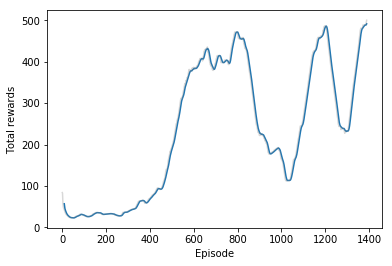

In [54]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

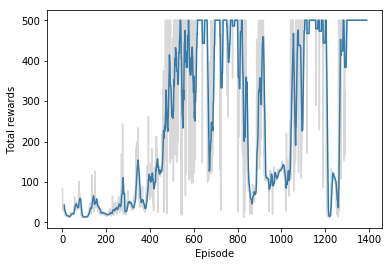

In [55]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

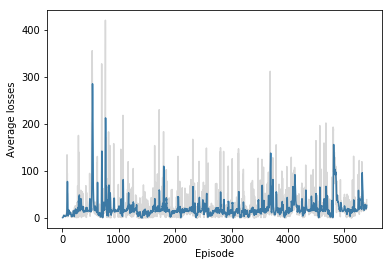

In [23]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episode/epoch
    for _ in range(10):
        total_reward = 0
        state = env.reset()
        initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
        
        # Steps/batches
        while True:
            env.render()
            action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                    feed_dict = {model.states: state.reshape([1, -1]), 
                                                                 model.initial_state: initial_state})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # At the end of each episode
        print('total_reward:{}'.format(total_reward))

# Close the env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.